# PROJECT INSTRUCTIONS


Based on the previous example, you are asked to carry out the following tasks:

A.:

- Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators.
- Add multiple technologies and provide references for the cost assumptions.
- Plot the dispatch time series for a week in summer and winter.
- Plot the annual electricity mix.
- Use the duration curves or the capacity factor to investigate the contribution of different technologies.

In [2]:
 # Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import gurobipy as gp

import functions as f # This includes e.g. annuity

In [3]:
# Initialize network and define snapshots
network = pypsa.Network()

year = '2015' # only 2015 is valid for the demands (electricity AND heat)
country = 'GBR' # All EU countries are valid?

hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                              f'{year}-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_year.values)

network.add("Bus",
            f"{country} electricity bus")

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [4]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [5]:
# add load to the bus
network.add("Load",
            "load",
            bus=f"{country} electricity bus",
            p_set=df_elec[country].values)

type(df_elec[country]),df_elec[country].values.shape

(pandas.core.series.Series, (8760,))

In [6]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,29059.0
2015-01-01 01:00:00,28663.0
2015-01-01 02:00:00,26626.0
2015-01-01 03:00:00,24778.0
2015-01-01 04:00:00,23212.0
...,...
2015-12-31 19:00:00,35944.0
2015-12-31 20:00:00,33128.0
2015-12-31 21:00:00,30488.0


In [7]:
# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

# load solar data
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

# Defining some lists and a dict that is used so make model building and visualization dynamic
VRE_techs = ['onshorewind', 'solar']
CF_dict = {'onshorewind': CF_wind, 'solar': CF_solar}
techs_labels = ['onshorewind', 'solar', 'OCGT', 'coal', 'nuclear', 'biomass'] # NG plant = natural gas plant
carriers = ['onshorewind', 'solar', 'gas', 'coal', 'nuclear', 'wood chips']
techs_colors = ['blue', 'orange', 'brown', 'grey', 'purple', 'green']

In [8]:
''' Define data needed to setup the generators in the Pypsa network '''

''' unit conversion constants and universal constants'''
dollar2euro = 0.9239 # [€/$] -- https://www.valutakurser.dk - 25/03-25
lbs2kg = 0.453592 # [kg/lbs] multiply by this to go from lbs/kWh to kg/kWh
kJ2MWh = 1/(10**3 * 60**2) # [MWh/kJ]
MMBtu2MWh = 0.293 # [MWh / MMBtu]
coal_energy_density = 24 / 60**2 * 10**3 # [MJ/kg] -> [MWh/t]
'''
# From Teknologikataloget (Version 2025: 2030-values): https://ens.dk/analyser-og-statistik/teknologikatalog-produktion-af-el-og-fjernvarme, pp. 209, 260, and 361/371 
    # technology: wind, solar, OCGT, coal, biomass
    # metric:     capital costs(wind, solar, OCGT, biomass), efficiencies (OCGT, biomass), lifetime

# https://iopscience.iop.org/article/10.1088/1748-9326/11/11/114010/meta -- their gas numbers match ours nicely
    # technology: coal
    # metric:     capital costs

# https://ourworldindata.org/grapher/coal-prices
    # technology: coal
    # metric:     fuel costs

# https://ourworldindata.org/grapher/natural-gas-prices
    # technology: gas
    # metric:     fuel costs
'''
gas_price_index_ratio_2023_2016 = 275.58/104.13 # drastic changes ¿primarily due to Russian invasion of Ukraine?
coal_price_index_ratio_2023_2016 = 215.30/99.87

'''
# https://www.gevernova.com/gas-power/resources/articles/2018/come-hele-or-high-water
    # technology: coal
    # metric:     efficiency

# https://www.sciencedirect.com/science/article/pii/S1364032121001301
    # technology: nuclear
    # metric:     capital costs, fuel/variable costs

# https://www.iaea.org/sites/default/files/29402043133.pdf
    # technoklogy: nuclear
    # metric:      lifetime

# https://www.sciencedirect.com/science/article/pii/S0196890422001297?via%3Dihub
    # technology: biomass
    # metric:     fuel costs
    # the price is given as 41 $/tonne and LHV in kJ/kg, so the conversion is a little tricky as may be noticed below
'''
lifetimes = [30, 25, 25, 15, 40, 25] # years

capital_costs = np.array([1.333, 0.26, 0.435, 1.75, 9, 3.1]) * 10**6 # €/MW, originally in M€/MW, pp. 209,260,371
'''# https://backend.orbit.dtu.dk/ws/portalfiles/portal/158807620/OffshoreOnshore_Energy_Policy_August_revision_28_8.pdf
    # More optimistic onshore wind capital costs -- without these the results are still interesting, though'''
#capital_costs[0] = 0.8e6
dict_capital_costs_annualized = {tech:f.annuity(lifetime, 0.07)*cost*(1+0.03) for tech,cost,lifetime in zip(techs_labels,capital_costs,lifetimes)}

efficiencies = np.array([1, # [MW_e/MW_th]
                         1,
                         0.43,
                         0.4,
                         1,
                         0.305])
dict_efficiencies = {tech:eff for tech,eff in zip(techs_labels, efficiencies)}

gas_co2_emissions = 52.91/10**3 # kg_CO2/kWh_th -> t_CO2/kWh_th -- from https://www.eia.gov/environment/emissions/co2_vol_mass.php
coal_co2_emissions = 95.99/10**3 # kg_CO2/kWh_th -> t_CO2/kWh_th

fuel_costs_dollars = np.array([0,  # -,-,$/MWh_th, $/MWh_th, $/MWh_e, $/MWh_th
                               0,
                               41.97, 
                               129.54/coal_energy_density, # $/t -> $/MWh_th 
                               10.11,
                               41/10**3/19970 / kJ2MWh]) # originally 41 $/tonne, HHV=19970 kJ/kg
fuel_costs = (fuel_costs_dollars
              * np.array([0, 0, dollar2euro, dollar2euro, dollar2euro, dollar2euro])) # €/MWh_th, MWh_e for nuclear
dict_fuel_costs = {tech:cost for tech,cost in zip(techs_labels, fuel_costs)}

dict_marginal_costs = {tech:dict_fuel_costs[tech] / dict_efficiencies[tech] for tech in techs_labels} # €/MWh_e

CO2_emissions = [0, # CO2_emissions [kgCO2/kWh_th=tCO2/MWh_th] for each carrier
                 0,
                 gas_co2_emissions/MMBtu2MWh,
                 coal_co2_emissions/MMBtu2MWh,
                 0,
                 0]  # biomass is assumed to be sourced sustainably...
network.add("Carrier", carriers, color=techs_colors, co2_emissions=CO2_emissions, overwrite=True)

Index(['onshorewind', 'solar', 'gas', 'coal', 'nuclear', 'wood chips'], dtype='object')

In [9]:
'''Only five objects are needed to dynamically define the generators:'''
#techs_labels
#carriers
#dict_capital_costs_annualized
#dict_marginal_costs
CFs = [CF_wind, CF_solar]

###################################
'''To get the same results as in the example from the assignment description, use these values INSTEAD:'''
''' There may be a few other lines in the code that should also be commented out, e.g. any lines including "biomass" '''
# techs_labels=["onshorewind", "solar", "OCGT"]
# carriers=["onshorewind", "solar", "gas"]

# capital_cost_onshorewind = f.annuity(30,0.07)*910000*(1+0.033) # in €/MW
# capital_cost_solar = f.annuity(25,0.07)*425000*(1+0.03) # in €/MW
# capital_cost_OCGT = f.annuity(25,0.07)*560000*(1+0.033) # in €/MW
# dict_capital_costs_annualized = {tech:val for tech,val in zip(techs_labels,[capital_cost_onshorewind,capital_cost_solar,capital_cost_OCGT])}

# fuel_cost = 21.6 # in €/MWh_th
# efficiency = 0.39 # MWh_elec/MWh_th
# marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
# dict_marginal_costs = {tech:val for tech,val in zip(techs_labels, [0,0,marginal_cost_OCGT])}

# network.generators.efficiency.loc["OCGT"] = efficiency
# network.add("Carrier", carriers, co2_emissions=[0,0,0.19], overwrite=True) # t_CO2/MWh_th
###################################

''' Dynamically define each generator in the Pypsa network '''
for i,tech in enumerate(techs_labels):
    if tech == "coal": # coal may NOT be extended
        network.add("Generator",
                    tech,
                    bus=f"{country} electricity bus",
                    p_nom_extendable=False,
                    p_nom=np.mean(network.loads_t.p_set) * 0.05, # new for coal -- it is set arbitrarily as 5% of the mean load until we have chosen a country
                    carrier=carriers[i],
                    capital_cost = dict_capital_costs_annualized[tech],
                    marginal_cost = dict_marginal_costs[tech],
                    p_max_pu = (CFs[i].values if tech in VRE_techs else 1),
                    efficiency = dict_efficiencies[tech],
                    overwrite=True) # kept  in case of re-running the code
    else:
        network.add("Generator",
                    tech,
                    bus=f"{country} electricity bus",
                    p_nom_extendable=True,
                    carrier=carriers[i],
                    capital_cost = dict_capital_costs_annualized[tech],
                    marginal_cost = dict_marginal_costs[tech],
                    p_max_pu = (CFs[i].values if tech in VRE_techs else 1),
                    efficiency = dict_efficiencies[tech],
                    overwrite=True) # kept  in case of re-running the code


In [10]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2015-01-01 00:00:00,0.606,0.0
2015-01-01 01:00:00,0.610,0.0
2015-01-01 02:00:00,0.592,0.0
2015-01-01 03:00:00,0.570,0.0
2015-01-01 04:00:00,0.552,0.0
...,...,...
2015-12-31 19:00:00,0.508,0.0
2015-12-31 20:00:00,0.426,0.0
2015-12-31 21:00:00,0.336,0.0


In [11]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshorewind,GBR electricity bus,PQ,,0.000000,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,GBR electricity bus,PQ,,0.000000,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
OCGT,GBR electricity bus,PQ,,0.000000,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
coal,GBR electricity bus,PQ,,1610.703134,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
nuclear,GBR electricity bus,PQ,,0.000000,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
biomass,GBR electricity bus,PQ,,0.000000,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [12]:
# We limit the use of wood chips by:
# 1) assuming that all biomass is wood chips
# 2) assuming that all internally produced biomass (70% of consumption) is sustainable and all imported is not and thus forbidden
# 3) assuming that the 541 PJ is in electrical units (MWh_e)
# The values above are for the UK and are from: from https://www.ieabioenergy.com/wp-content/uploads/2024/12/CountryReport2024_UK_final.pdf 
PJ2MWh = 10**9 / 60**2
biomass_imported = 0.3
biomass_available = 541 * PJ2MWh * (1-biomass_imported) # MWh_th

network.carriers["track_biomass"] = [0, 0, 0, 0, 0, 1.0] # count 1 MWh for each MWh of wood chips used and none for the others

network.add(
    "GlobalConstraint",
    "BiomassLimit",
    carrier_attribute="track_biomass",
    sense="<=",
    constant=biomass_available / network.generators.efficiency["biomass"],
    overwrite=True
)
network.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth,track_biomass
Carrier,,,,,,
onshorewind,0.000000,blue,,inf,0.0,0.0
solar,0.000000,orange,,inf,0.0,0.0
gas,0.180580,brown,,inf,0.0,0.0
coal,0.327611,grey,,inf,0.0,0.0
nuclear,0.000000,purple,,inf,0.0,0.0
wood chips,0.000000,green,,inf,0.0,1.0


In [13]:
env = gp.Env(empty=True) # Initialize a gurobipy-environment in which we can disable unnecessary outputs
env.setParam("OutputFlag", 0)  # Fully disable output
env.start()

network.optimize(solver_name='gurobi', solver_options={"env": env})

Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
INFO:linopy.io: Writing time: 1.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113886 duals
Objective: 1.71e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [14]:
print(network.objective / 10**9 ) #in 10^9 €

17.13748591300819


In [15]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    60.729192
dtype: float64


In [16]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind    36.052906
solar          69.670683
OCGT           32.663464
coal            1.610703
nuclear         0.000000
biomass        16.350188
Name: p_nom_opt, dtype: float64

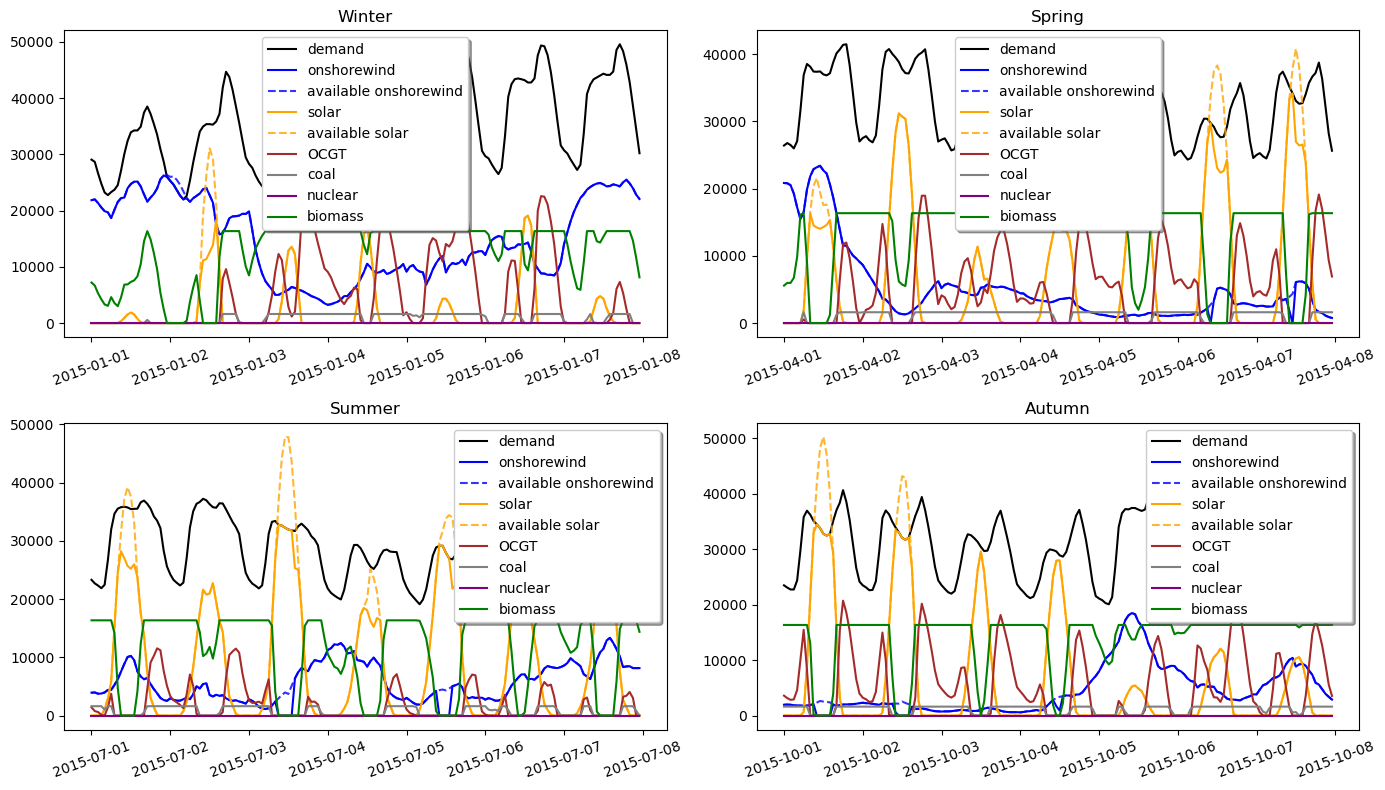

In [17]:
import matplotlib.pyplot as plt

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
start_index = np.array([0, 24*90, 24*181, 24*273]) # 1st of Jan/Apr/Jul/Oct
end_index = start_index + 24*7 # add a week to each of the indexes


fig, ax = plt.subplots(2,2, figsize=(14,8))
ax=ax.flatten()

for i,season in enumerate(seasons):
    ax[i].plot(network.loads_t.p['load'][start_index[i]:end_index[i]],
               color='black',
               label='demand')
    for tech, color in zip(techs_labels, techs_colors):
        ax[i].plot(network.generators_t.p[tech][start_index[i]:end_index[i]],
                   color=color,
                   label=tech)
        if tech in VRE_techs:
            ax[i].plot(network.generators.p_nom_opt[tech] * CF_dict[tech][start_index[i]:end_index[i]],
                       color=color,
                       alpha=0.8,
                       linestyle='--',
                       label=f'available {tech}')
    ax[i].set_title(season)
    ax[i].legend(fancybox=True, shadow=True, loc='best', prop={'size': 10})
    ax[i].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

Text(0.5, 1.07, 'Electricity mix')

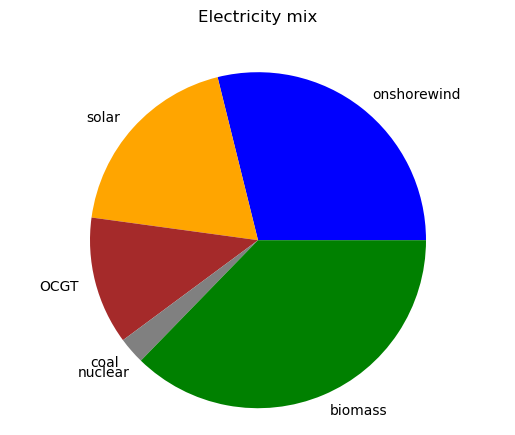

In [18]:
sizes = [network.generators_t.p[tech].sum()
         for tech in techs_labels]

plt.pie(sizes,
        colors=techs_colors,
        labels=techs_labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [19]:
np.array(sizes) / 10**6, biomass_available / 10**6 # in TWh. Compare the biomass used to the biomass available to verify if we are using everything


(array([ 81.46518386,  53.54804608,  34.70745589,   7.28005872,
          0.        , 105.19444444]),
 105.19444444444443)

In [20]:
# Generator revenues
network.generators_t.p.multiply(network.buses_t.marginal_price.to_numpy()).sum().div(1e6) # € -> M€

Generator
onshorewind    3989.049524
solar          1601.036239
OCGT           4385.637394
coal            700.915714
nuclear           0.000000
biomass        8278.294390
dtype: float64

In [21]:
# Total expenditures by carriers
( network.statistics.capex(groupby="carrier").add(
    network.statistics.opex(groupby="carrier"), fill_value=0
    )
).div(1e6) # € -> M€

component  carrier    
Generator  coal            645.500411
           gas            4385.637394
           onshorewind    3989.049524
           solar          1601.036239
           wood chips     6835.028243
dtype: float64

The coal expenditures do not match the coal revenues since the installed coal capacity was not a part of the optimization problem.

In [22]:
# emissions by GENERATOR
emissions = (
    network.generators_t.p
    / network.generators.efficiency
    * network.generators.carrier.map(network.carriers.co2_emissions)
)  # t/h
emissions.sum().div(1e6)  # tCO2 -> MtCO2

Generator
onshorewind     0.000000
solar           0.000000
OCGT           14.575534
coal            5.962567
nuclear         0.000000
biomass         0.000000
dtype: float64

In [23]:
# emissions by CARRIER
emissions = (
    network.generators_t.p
    / network.generators.efficiency
    * network.generators.carrier.map(network.carriers.co2_emissions)
).T.groupby(network.generators.carrier).sum().T  # t/h
emissions.sum().div(1e6), emissions.sum().div(1e6).sum()  # tCO2 -> MtCO2

(carrier
 coal            5.962567
 gas            14.575534
 nuclear         0.000000
 onshorewind     0.000000
 solar           0.000000
 wood chips      0.000000
 dtype: float64,
 20.538100570936464)

In [24]:
network.generators.efficiency, network.carriers.co2_emissions

(Generator
 onshorewind    1.000
 solar          1.000
 OCGT           0.430
 coal           0.400
 nuclear        1.000
 biomass        0.305
 Name: efficiency, dtype: float64,
 Carrier
 onshorewind    0.000000
 solar          0.000000
 gas            0.180580
 coal           0.327611
 nuclear        0.000000
 wood chips     0.000000
 Name: co2_emissions, dtype: float64)

# A: Load duration curve

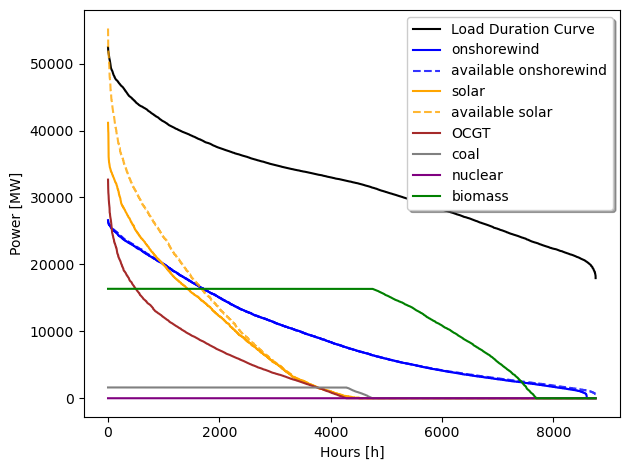

In [25]:
LDC = network.loads_t.p_set.sort_values(by='load', ascending=False) # MWh
LDC_idx = range(1,len(LDC)+1) # hours

CF_sorted_dict = {tech: CF_dict[tech].sort_values(ascending=False) for tech in VRE_techs}

plt.plot(LDC_idx,
         LDC,
         label='Load Duration Curve',
         color='black')
for tech, color in zip(techs_labels, techs_colors):
    plt.plot(LDC_idx,
               network.generators_t.p[tech].sort_values(ascending=False),
               color=color,
               label=tech)
    if tech in VRE_techs:
        plt.plot(LDC_idx,
                 network.generators.p_nom_opt[tech] * CF_sorted_dict[tech],
                 label=f"available {tech}",
                 linestyle='--',
                 alpha=0.8,
                 color=color)
        
plt.xlabel('Hours [h]')
plt.ylabel('Power [MW]')
plt.tight_layout()
plt.legend(fancybox=True, shadow=True, loc='best', prop={'size': 10})
plt.show()


# B: Sensitivity to global CO2 constraint

In [26]:
# The model is run multiple times with different CO2 constraints 
# corresponding to historical emissions and targets

# Add the CO2 constraint:
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=10**10,
    overwrite=True
)

# Define limits in MtCO2: numbers are for "Electricity and heat producers" from https://www.iea.org/countries/united-kingdom/emissions
# Define limits in MtCO2: numbers include heat because they are for "Energy and Utilities" from https://klimaraadet.dk/da/klima-i-tal
global_CO2_limits = [189,  # 2000
                     68,   # 2022
                     3,    # 2022 CO2 emissions of a country with similar population size but low emissions: Tanzania
                     0]    # CO2-neutral

# Run the model
sensitivity_obj = {}
sensitivity_emis = {}
sensitivity_prod = {}
sensitivity_caps = {}
sensitivity_CO2price = {}
for co2_limit in global_CO2_limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2_limit * 1e6 # tCO2
    network.optimize(solver_name='gurobi', solver_options={"env": env})
    sensitivity_obj[co2_limit] = network.objective / 1e6 # € -> M€
    sensitivity_emis[co2_limit] = (
                                    network.generators_t.p
                                    / network.generators.efficiency
                                    * network.generators.carrier.map(network.carriers.co2_emissions)
                                  ).T.groupby(
                                      network.generators.carrier
                                  ).sum().T.sum().div(1e6).sum()  # tCO2 -> MtCO2
    sensitivity_prod[co2_limit] = [network.generators_t.p[tech].sum()
                                   for tech in techs_labels]
    sensitivity_caps[co2_limit] = network.generators.p_nom_opt.copy() # in MW
    sensitivity_CO2price[co2_limit] = - network.global_constraints.mu.values[0] # in €/kgCO2, '.values[0]' is simply formatting

Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
INFO:linopy.io: Writing time: 1.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52565 primals, 113887 duals
Objective: 1.71e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['GBR electricity bus'], dtype='object', name='Bus')
Index(['GBR electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]
INFO:linopy.i

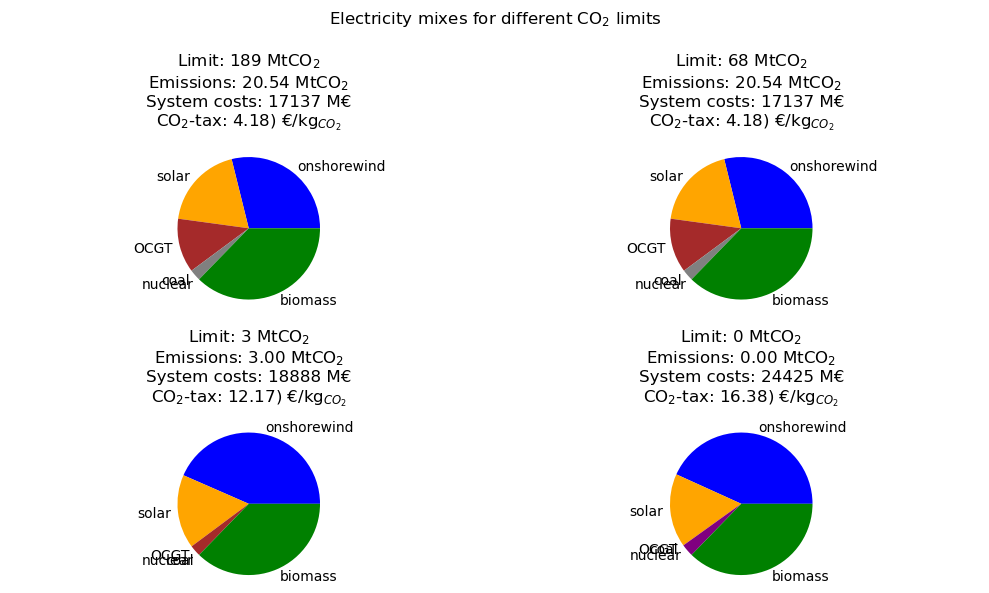

In [27]:

# Plot the results:
fig, ax = plt.subplots(2,2,figsize=(10,6))#, constrained_layout=True)
ax = ax.flatten()

for i,co2_limit in enumerate(global_CO2_limits):
    sizes = sensitivity_prod[co2_limit]
    ax[i].pie(sizes,
            colors=techs_colors,
            labels=techs_labels,
            wedgeprops={'linewidth':0})
    ax[i].axis('equal')

    ax[i].set_title(f'Limit: {co2_limit} MtCO$_2$\nEmissions: {sensitivity_emis[co2_limit]:.2f} MtCO$_2$\nSystem costs: {sensitivity_obj[co2_limit]:.0f} M€\nCO$_2$-tax: {sensitivity_CO2price[co2_limit]:.2f})'+' €/kg$_{CO_2}$', y=1.1)
plt.suptitle('Electricity mixes for different CO$_2$ limits')
plt.tight_layout()

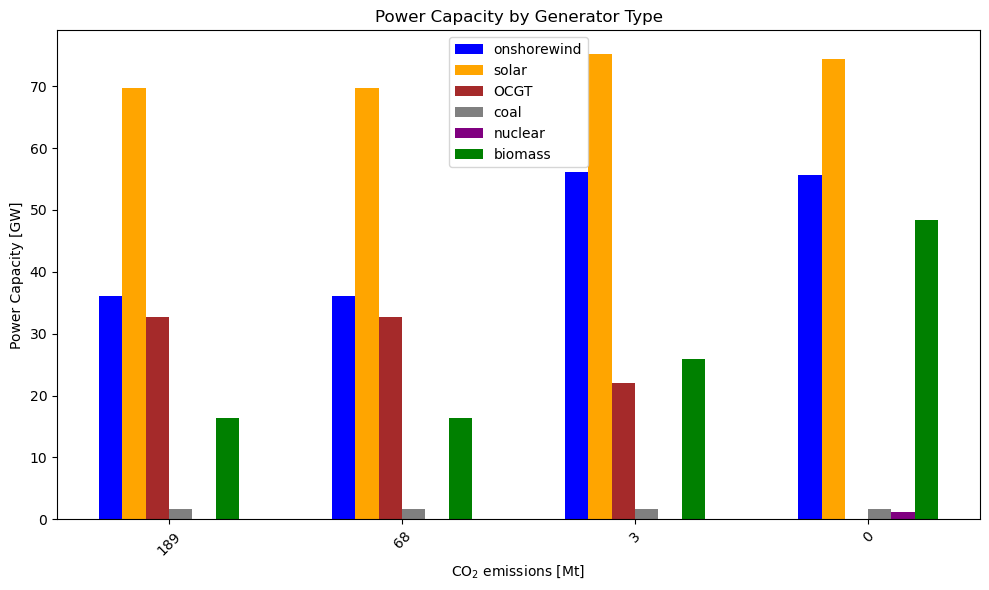

In [28]:
# Plot bars:
xticks_spacing = 1.5
x = np.arange(len(global_CO2_limits)) * xticks_spacing  # X positions
width = 0.15  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i,tech in enumerate(techs_labels):
    ax.bar(x + i * width, [sensitivity_caps[co2_limit][tech]/1e3 for co2_limit in global_CO2_limits], width, color=techs_colors[i], label=tech)

# Formatting:
ax.set_xticks(x + width * (len(techs_labels) / 2 - 0.5))
ax.set_xticklabels([str(limit) for limit in global_CO2_limits])
ax.set_xlabel("CO$_2$ emissions [Mt]")
ax.set_ylabel("Power Capacity [GW]")
ax.set_title("Power Capacity by Generator Type")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

Notice, that it is required to overinvest huge amounts of money in biomass capacity even though the amount of electricity is entirely unchanged from 189 to 0 Mt (as seen in the pie charts above).

# C: Sensitivity to interannual variability of solar and wind generation

In [29]:
# 1) Repeat the code from B but where we reinitialize the CO2 limit to be unconstrained
# 2) Load new data files for solar and wind